In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import galsim

In [2]:
# Some constants
# --------------
#
# LSST effective area in meters^2
A = 319/9.6  # etendue / FoV.  I *think* this includes vignetting

# zeropoints from DK notes in photons per second per pixel
# should eventually compute these on the fly from filter throughput functions.
s0 = {'u': A*0.732,
      'g': A*2.124,
      'r': A*1.681,
      'i': A*1.249,
      'z': A*0.862,
      'y': A*0.452}
# Sky brightnesses in AB mag / arcsec^2.
# stole these from http://www.lsst.org/files/docs/gee_137.28.pdf
# should eventually construct a sky SED (varies with the moon phase) and integrate to get these
B = {'u': 22.8,
     'g': 22.2,
     'r': 21.3,
     'i': 20.3,
     'z': 19.1,
     'y': 18.1}
# number of visits
# From LSST Science Book
fiducial_nvisits = {'u': 56,
                    'g': 80,
                    'r': 180,
                    'i': 180,
                    'z': 164,
                    'y': 164}

In [3]:
np.sqrt(A/np.pi)*2

6.504512974742653

In [4]:
s0

{'u': 24.323750000000004,
 'g': 70.57875000000001,
 'r': 55.858229166666675,
 'i': 41.50322916666668,
 'z': 28.64354166666667,
 'y': 15.019583333333335}

In [5]:
# Sky brightness per arcsec^2 per second
sbar = {}
for k in B:
    sbar[k] = s0[k] * 10**(-0.4*(B[k]-24.0))


In [6]:
sbar

{'u': 73.45655065912851,
 'g': 370.40254535103674,
 'r': 671.5636230779237,
 'i': 1253.3774832411411,
 'z': 2612.3220477542613,
 'y': 3440.7877616383257}

In [7]:
class ETC(object):
    def __init__(self, band, pixel_scale=None, stamp_size=None, threshold=0.0,
                 nvisits=None, visit_time=30.0):
        self.pixel_scale = pixel_scale
        self.stamp_size = stamp_size
        self.threshold = threshold
        self.band = band
        if nvisits is None:
            nvisits = fiducial_nvisits[band]
        self.nvisits = nvisits
        self.visit_time =  visit_time
        self.exptime = self.nvisits * self.visit_time
        self.sky = sbar[band] * self.exptime * self.pixel_scale**2
        self.sigma_sky = np.sqrt(self.sky)
        self.s0 = s0[band]

    def draw(self, profile, mag, noise=False):
        img = galsim.ImageD(self.stamp_size, self.stamp_size, scale=self.pixel_scale)
        flux = self.s0 * 10**(-0.4*(mag - 24.0)) * self.exptime
        profile = profile.withFlux(flux)
        profile.drawImage(image=img)
        if noise:
            gd = galsim.GaussianNoise(bd, sigma=self.sigma_sky)
            img.addNoise(gd)
        return img

    def SNR(self, profile, mag):
        img = self.draw(profile, mag, noise=False)
        mask = img.array > (self.threshold * self.sigma_sky)
        imgsqr = img.array**2*mask
        signal = imgsqr.sum()
        noise = np.sqrt((imgsqr * self.sky).sum())
        return signal / noise

    def nphot(self, mag):
        return self.s0 * 10**(-0.4*(mag - 24.0)) * self.exptime

    def err(self, profile, mag):
        snr = self.SNR(profile, mag)
        return 2.5 / np.log(10) / snr

    def display(self, profile, mag, noise=True):
        img = self.draw(profile, mag, noise)
        #import matplotlib.pyplot as plt
        #import matplotlib.cm as cm
        #print("Peak photons = %.1f"%img.array.max())
        #plt.imshow(img.array, cmap=cm.Greens, interpolation='nearest')
        #plt.colorbar()
        #plt.show()
        return img.array.max()


In [8]:
fwhm = 0.70  # PSF FWHM - arcseconds
pixel_scale = 0.2 # pixel scale in arcseconds
stamp_size = 11 # stamp size in pixels
sersic_n = 0.5 # This basically gives a Gaussian
sersic_hlr = 0.2 # This is much smaller than the PSF, so is basically a point source
nvisits = 1

sat_level = 180000

psf = galsim.Kolmogorov(fwhm=fwhm)
gal = galsim.Sersic(n=sersic_n, half_light_radius=sersic_hlr)
profile = galsim.Convolve(psf, gal)
colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']

In [10]:
# And some random numbers for drawing
bd = galsim.BaseDeviate(1)

etc = ETC('u', pixel_scale=pixel_scale, stamp_size=stamp_size, nvisits=nvisits)
mag = 14
etc.display(profile, mag)

325710.76450129435

u: 14.80
g: 16.00
r: 15.60
i: 15.40
z: 15.00
y: 14.20


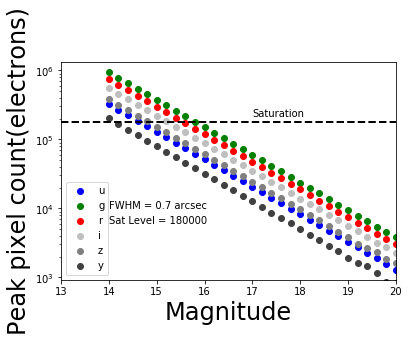

In [11]:
for c, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    etc = ETC(band, pixel_scale=pixel_scale, stamp_size=stamp_size, nvisits=nvisits)
    mags = []
    npeaks = []
    for m in range(31):
        mag = 14.0 + 0.2 * m
        mags.append(mag)
        npeaks.append(etc.display(profile, mag))
        #print("band = %s, mag = %.1f, nphot = %.1f, npeak = %.1f"%(band, mag, etc.nphot(mag), etc.display(profile, mag)))
        
    plt.scatter(mags, npeaks, label=band, color=colors[c])
    print('%s: %.2f'%(band, mags[np.argmax(np.array(npeaks)<sat_level)]))
plt.plot([13.0,20.0],[sat_level, sat_level], ls = '--', lw = 2, color='black')
plt.text(17.0, sat_level*1.20, "Saturation", color = 'black')
plt.text(14.0, 10000, "FWHM = %.1f arcsec"%fwhm, color = 'black')
plt.text(14.0, 6000, "Sat Level = %d"%sat_level, color = 'black')
plt.legend()
plt.yscale('log')
plt.xlim(13.0,20.0)
plt.xlabel('Magnitude', fontsize=24)
plt.ylabel('Peak pixel count(electrons)', fontsize=24)
plt.savefig('Peak_count_by_band_07Dec19.pdf')